# PCs 3d visualization from the MWLMC interaction  from GC23

# Workflow:

1. Load coefficients 
    - From H5 file
    - From array
2. Make channels 

3. Run MSSA

4. Diagnostics
    - Eigenvalues
    - PCs
    - Power spectrum of PCs
    - Wcorr
    - PC grouping 

5. Field reconstruction 
    - 3d Reconstruction


In [25]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import h5py
import os
from scipy.linalg import norm
import k3d

import pyEXP
#sys.path.append('../scf_coefficients/')
#import scf_utils
plt.style.use('~/matplotlib.mplstyle')

In [34]:
sys.path.append('../')
sys.path.append('../../notebook/mwlmc_EXP/')

In [36]:
from mwlmc_mssa_mike import slice_fields

# 1. Load coefficients 

In [4]:
#runtag = 'run26mlde'
mwconfig = """
id: sphereSL
parameters:
  numr: 500
  rmin: 0.01
  rmax: 600
  Lmax: 4
  nmax: 15
  scale: 40.85
  modelname: SLGrid.empirical.halo.isolate.mwlmc5v12
  cachename: .slgrid_sph_cache_halo_mwlmc5v12
"""

mwbasis = pyEXP.basis.Basis.factory(mwconfig)

---- SLGridSph::ReadH5Cache: read basis cache <.slgrid_sph_cache_halo_mwlmc5v12.h5>


In [5]:
mw_basis_grid = mwbasis.getBasis(-3, 2.5, 200)

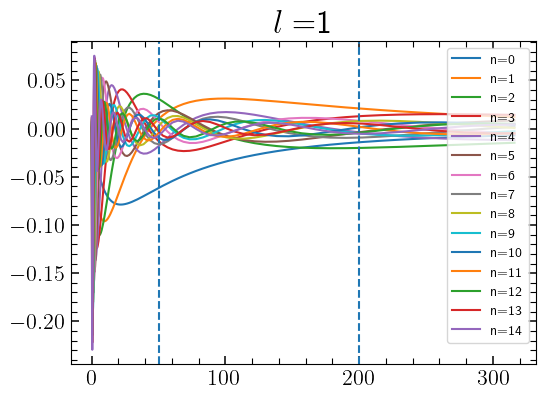

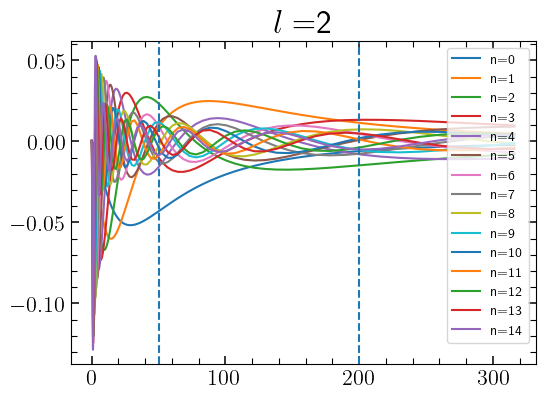

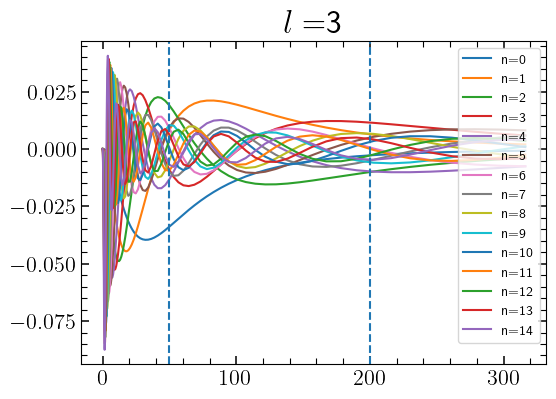

In [6]:
r = np.logspace(-3, 2.5, 200)

for l in range(1, 4):
    for n in range(15):
        plt.plot(r, mw_basis_grid[l][n], label='n={}'.format(n))
        plt.legend()
    plt.axvline(50, ls='--')
    plt.axvline(200, ls='--')
    plt.title('$l=${}'.format(l))
    plt.savefig('basis_mwlmc5v12_nmax15_max4_l_{}.png'.format(l), bbox_inches='tight')
    plt.show()


In [7]:
ff = h5py.File('.slgrid_sph_cache_halo_mwlmc5v12.h5')

In [8]:
# Load pre-computed coefficients 
mwcoefs = pyEXP.coefs.Coefs.factory('../../notebook/MWLMC5_halov12.h5')

In [9]:
ac = mwcoefs.getAllCoefs()

In [10]:
mwcoefs_original = mwcoefs.deepcopy()

In [11]:
def slice_3d_fields(basis, coefficients, time=0, 
                 npoints=300, grid_limits=(-300, 300), prop='dens', monopole_only=False):
    """
    Plots a slice projection of the fields of a simulation.

    Args:
    basis (obj): object containing the basis functions for the simulation
    coefficients (obj): object containing the coefficients for the simulation
    time (float): the time at which to plot the fields
    npoints (int, optional): the number of grid points in each dimension
    grid_limits (tuple, optional): the limits of the grid in the x and y dimensions, in the form (x_min, x_max)
    prop (str, optional): the property to return. Can be 'dens' (density), 'pot' (potential), or 'force' (force).
    monopole_only (bool, optional): whether to return the monopole component in the returned property value.

    Returns:
    array or list: the property specified by `prop`. If `prop` is 'force', a list of the x, y, and z components of the force is returned.
                    Also returns the grid used to compute slice fields. 
    """
    x = np.linspace(grid_limits[0], grid_limits[1], npoints)
    xgrid = np.meshgrid(x, x, x)
    xg = xgrid[0].flatten()
    yg = xgrid[1].flatten() 
    zg = xgrid[2].flatten()
  
    

    N = len(xg)
    rho0 = np.zeros_like(xg)
    pot0 = np.zeros_like(xg)
    rho = np.zeros_like(xg)
    pot = np.zeros_like(xg)
    basis.set_coefs(coefficients.getCoefStruct(time))

    for k in range(0, N):
        rho0[k], pot0[k], rho[k], pot[k], fx, fy, fz = basis.getFields(xg[k], yg[k], zg[k])
    
    dens = rho.reshape(npoints, npoints, npoints)
    pot = pot.reshape(npoints, npoints, npoints)
    dens0 = rho0.reshape(npoints, npoints, npoints)
    pot0 = pot0.reshape(npoints, npoints, npoints)
    
    ret = []

    if 'dens' in prop:
        if monopole_only:
            ret.append(dens0)
        ret.append(dens0)
        ret.append(dens) 

    if 'pot' in prop:
        if monopole_only:
            return ret.append(pot0)
        ret.append(pot0)
        ret.apend(pot)

    if 'force' in prop:
        ret.append() [fx.reshape(npoints, npoints, npoints), fy.reshape(npoints, npoints, npoints), fz.reshape(npoints, npoints, npoints)], xgrid
    
    ret.append(xgrid)
    return ret


In [40]:
dens03d, dens3d, grid3d = slice_3d_fields(mwbasis, mwcoefs_original, time=2.1, npoints=100)

In [21]:
np.savetxt('./test_3d_density_t_2.1.txt', np.array([dens03d.flatten(), dens3d.flatten(), grid3d[0].flatten()]).T)

NameError: name 'grid' is not defined

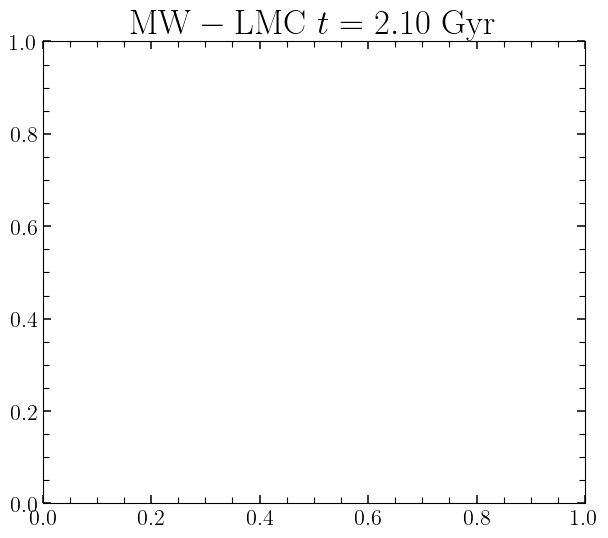

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))


#plt.plot(pos[:,1]-posm[:,1], pos[:,2]-posm[:,2], c='k')
ax.set_title(r'$\rm{MW-LMC}$' + '$\ t={:.2f}$'.format(2.1) + r'$\ \rm{Gyr}$', fontsize=25)
im = ax.contourf(grid[0], grid[1], (rho_mon+rho_all)/rho_mon - 1, levels=np.linspace(-0.7, 0.7, 101), 
                 cmap='RdBu_r', vmin=-0.5, vmax=0.5)
#ax.contour(grid[0], grid[1], (rho_mon+rho_all)/rho_mon - 1, levels=np.linspace(-0.5, 0.5, 8), colors='k', lw=1.0, vmin=-0.5, vmax=0.5)
fig.colorbar(im)
ax.set_xlim(-300, 300) 
ax.set_ylim(-300, 300)
ax.set_xlabel(r'$\rm{y[kpc]}$', fontsize=25)
ax.set_ylabel(r'$\rm{z[kpc]}$', fontsize=25)
plt.savefig('wake_l_0_4.png', bbox_inches='tight')

In [23]:
keylst0 = mwcoefs.makeKeys([0])
keylst1 = mwcoefs.makeKeys([1])
keylst2 = mwcoefs.makeKeys([2])
keylst3 = mwcoefs.makeKeys([3])
keylst4 = mwcoefs.makeKeys([4])

keylst =  keylst1 + keylst2
print("Keys=", keylst)
print(len(keylst))


Keys= [[1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 0, 3], [1, 0, 4], [1, 0, 5], [1, 0, 6], [1, 0, 7], [1, 0, 8], [1, 0, 9], [1, 0, 10], [1, 0, 11], [1, 0, 12], [1, 0, 13], [1, 0, 14], [1, 1, 0], [1, 1, 1], [1, 1, 2], [1, 1, 3], [1, 1, 4], [1, 1, 5], [1, 1, 6], [1, 1, 7], [1, 1, 8], [1, 1, 9], [1, 1, 10], [1, 1, 11], [1, 1, 12], [1, 1, 13], [1, 1, 14], [2, 0, 0], [2, 0, 1], [2, 0, 2], [2, 0, 3], [2, 0, 4], [2, 0, 5], [2, 0, 6], [2, 0, 7], [2, 0, 8], [2, 0, 9], [2, 0, 10], [2, 0, 11], [2, 0, 12], [2, 0, 13], [2, 0, 14], [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 1, 3], [2, 1, 4], [2, 1, 5], [2, 1, 6], [2, 1, 7], [2, 1, 8], [2, 1, 9], [2, 1, 10], [2, 1, 11], [2, 1, 12], [2, 1, 13], [2, 1, 14], [2, 2, 0], [2, 2, 1], [2, 2, 2], [2, 2, 3], [2, 2, 4], [2, 2, 5], [2, 2, 6], [2, 2, 7], [2, 2, 8], [2, 2, 9], [2, 2, 10], [2, 2, 11], [2, 2, 12], [2, 2, 13], [2, 2, 14]]
75


In [22]:
keylst.remove([1, 0, 0])
keylst.remove([2, 0, 0])
keylst.remove([1, 0, 1])
keylst.remove([1, 0, 2])
keylst.remove([2, 0, 1])
keylst.remove([2, 0, 2])

In [24]:
name = 'dark halo'
config_mssa = {name: (mwcoefs, keylst, [])}

In [25]:
window = int(len(mwcoefs.Times())/4)
npc = 20

print("Window={} PC number={}".format(window, npc))

Window=98 PC number=20


In [26]:
ssa = pyEXP.mssa.expMSSA(config_mssa, window, npc)
ev = ssa.eigenvalues()

---- Eigen is using 32 threads
shape U = 11760 x 20


Text(0.5, 1.0, 'Eigenvalues by index l=1,2, window=t/4.')

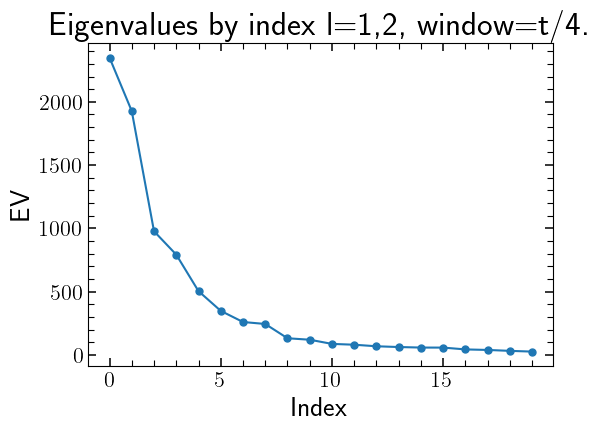

In [27]:
plt.plot(ev, 'o-')
plt.xlabel("Index")
plt.ylabel("EV")
plt.title("Eigenvalues by index l=1,2, window=t/4.")
#plt.savefig('ev_mwlmc5_gc19_nmax15_lmax4_l_1-2_window_t_0.25.png', bbox_inches='tight')

Text(0.5, 1.0, 'l=1,2, window=t/4.')

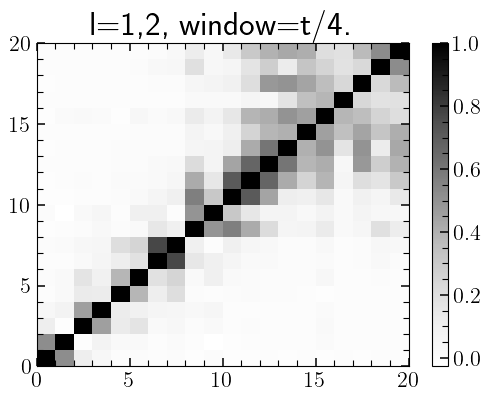

In [28]:

ssa.reconstruct([*range(npc)])
mat = ssa.wCorrAll()
x = plt.pcolormesh(mat, cmap='Greys')
plt.colorbar(x)
plt.title('l=1,2, window=t/4.')
#plt.savefig('wcorr_l_1-2_gc19_nmax15_lmax4_window_t_0.25.png', bbox_inches='tight')

In [29]:
#def mssa_diagnostic(sisa):
#    # DFT
#    freq, power = sisa.pcDFT()

    # Wcorr
    
    # PCs 

In [30]:
freq, power = ssa.pcDFT()


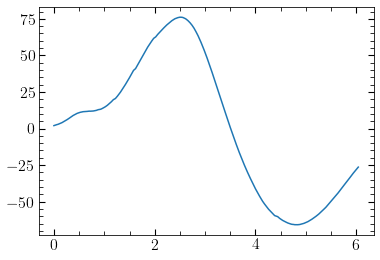

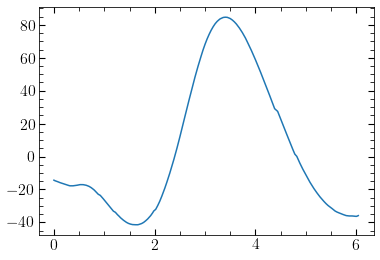

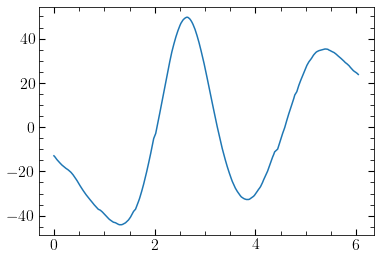

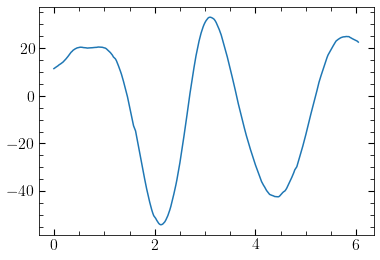

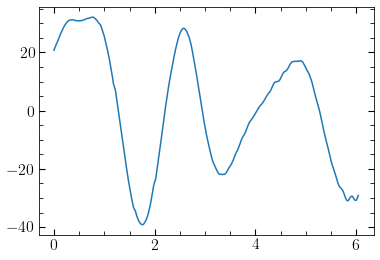

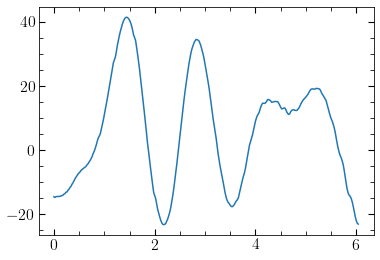

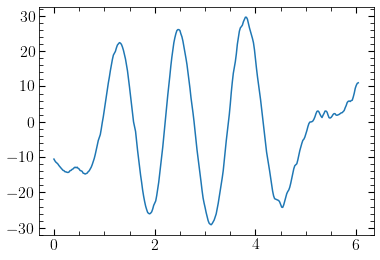

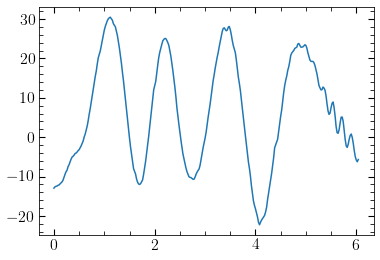

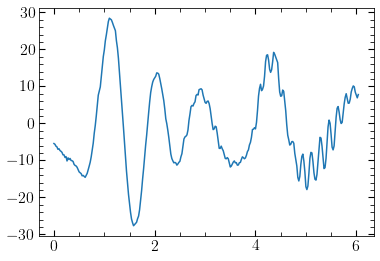

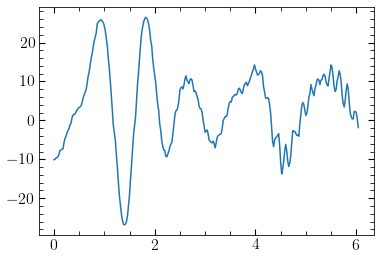

In [30]:
#for m in [0, 1, 2, 3, 4]:
pcs = ssa.getPC()
ntim = pcs.shape[0]
for n in range(0, 10):
    plt.plot(mwcoefs.Times()[0:ntim], pcs[:,n], label=str(n))
    plt.show()

Text(0, 0.5, 'Power')

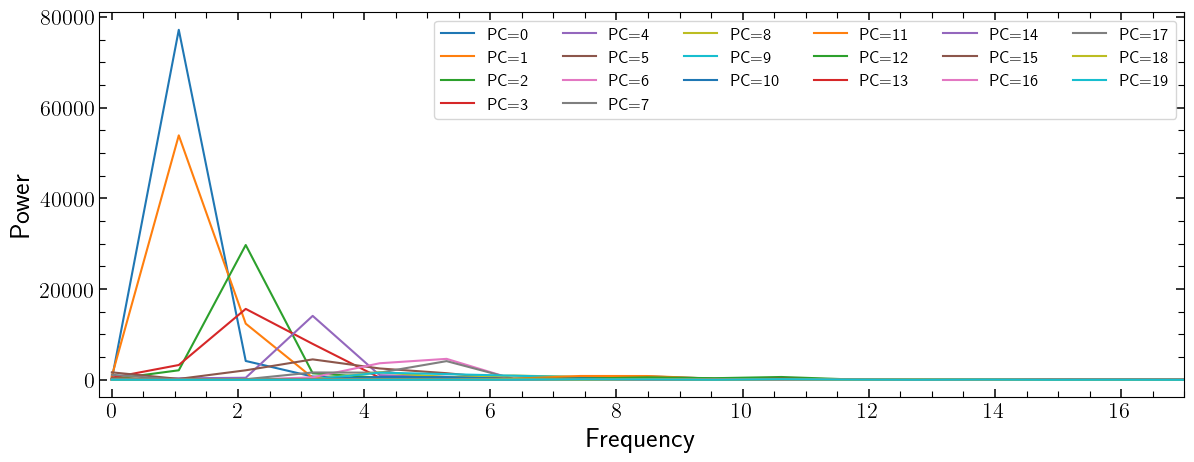

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
for i in range(20):
    ax.plot(freq[0:18],power[0:18,i], label='PC={}'.format(i))
ax.legend(ncol=6, fontsize=12)
ax.set_xlim(-0.2, 17)
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
#plt.savefig('frew_power_mwlmc5_l1-2_window_0.25_t.png', bbox_inches='tight')

In [41]:
ssa.reconstruct([0, 1])
mwcoefs.zerodata() # <---replace with reconstructed
newdata = ssa.getReconstructed()
_, dens3d, grid3d = slice_3d_fields(mwbasis, mwcoefs, time=2.1, npoints=100)
np.savetxt('./wake_PC01_3d_density_t_{}.txt'.format(), np.array([dens03d.flatten(), dens3d.flatten(), grid3d[0].flatten()]).T)


In [22]:
times = mwcoefs.Times()

In [28]:
mwconfig

'\nid: sphereSL\nparameters:\n  numr: 500\n  rmin: 0.01\n  rmax: 600\n  Lmax: 4\n  nmax: 15\n  scale: 40.85\n  modelname: SLGrid.empirical.halo.isolate.mwlmc5v12\n  cachename: .slgrid_sph_cache_halo_mwlmc5v12\n'

In [ ]:
params_list = {}
params_list['rmin'] = rmin
params_list['rmax'] = rmax
params_list['numr'] = numr
params_list['scale'] = scale
params_list['nmax'] = lmax
params_list['lmax'] = nmax
params_list['sim_name'] = numr



In [24]:
filename = 'MWLMC5_PC01_fields_reconstruction.h5'


def write_3d_fields(filename, field_names, fields, time, config_file):
    # Check if file exists
    if os.path.isfile(filename) == True:
        fields = h5py.File(filename, 'r+')
    else:
    # Create file
        fields = h5py.File(filename, 'w')
        fields.
    # Write header
   
    # Write field
    snap_fields = fields.create_group("snap_{:03d}".format(time)

    for f in len(field_names):                                  
        snap_fields[field_names[f]] = fields[f]
                                  

NameError: name 'filename' is not defined

In [42]:
for t in range(len(times)):
    _, dens3d, grid3d = slice_3d_fields(mwbasis, mwcoefs, time=2.1, npoints=100)
    np.savetxt('./wake_PC01_3d_density_t_{:03d}.txt'.format(t), np.array([dens03d.flatten(), dens3d.flatten(), grid3d[0].flatten()]).T)


array([[[4.48163325e-11, 4.62060941e-11, 4.76700368e-11, ...,
         4.76700368e-11, 4.62060941e-11, 4.48163325e-11],
        [4.62060941e-11, 4.77009789e-11, 4.92080582e-11, ...,
         4.92080582e-11, 4.77009789e-11, 4.62060941e-11],
        [4.76700368e-11, 4.92080582e-11, 5.07591690e-11, ...,
         5.07591690e-11, 4.92080582e-11, 4.76700368e-11],
        ...,
        [4.76700368e-11, 4.92080582e-11, 5.07591690e-11, ...,
         5.07591690e-11, 4.92080582e-11, 4.76700368e-11],
        [4.62060941e-11, 4.77009789e-11, 4.92080582e-11, ...,
         4.92080582e-11, 4.77009789e-11, 4.62060941e-11],
        [4.48163325e-11, 4.62060941e-11, 4.76700368e-11, ...,
         4.76700368e-11, 4.62060941e-11, 4.48163325e-11]],

       [[4.62060941e-11, 4.77009789e-11, 4.92080582e-11, ...,
         4.92080582e-11, 4.77009789e-11, 4.62060941e-11],
        [4.77009789e-11, 4.92399176e-11, 5.07919652e-11, ...,
         5.07919652e-11, 4.92399176e-11, 4.77009789e-11],
        [4.92080582e-11, 

In [37]:
def pcs_densities(sisa, coeficients, basis, rhomon, pcs, t=2.1):
    """
    
    TODO: remove suplots that are not used
    
    """

    npcs = len(pcs)

    
    nrows = int(npcs/4) + 1 
    ncols = 4
    print('computing {} pcs'.format(npcs))
    fig, ax = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), sharex=True, sharey=True)
    fig.patch.set_facecolor('w')
    
    axs = ax.flatten()
    
    axs[npcs].set_xlim(-300, 300) 
    axs[npcs].set_ylim(-300, 300)
    axs[npcs].set_xlabel(r'$\rm{y[kpc]}$', fontsize=25)
    axs[0].set_ylabel(r'$\rm{z[kpc]}$', fontsize=25)

    
    for p in range(npcs):
    
        sisa.reconstruct(pcs[p])
        coeficients.zerodata() # <---replace with reconstructed
        newdata = sisa.getReconstructed()

        rho_mon_pcn, rho_all_pcn, grid = slice_fields(basis, coeficients, npoints=100, time=t, rmax=300)

        #plt.plot(pos[:,1]-posm[:,1], pos[:,2]-posm[:,2], c='k')
        im = axs[p].contourf(grid[0], grid[1], (rhomon+rho_all_pcn)/rhomon - 1, levels=np.linspace(-0.7, 0.7, 101), 
                             cmap='RdBu_r', vmin=-0.5, vmax=0.5)

        cbar = fig.colorbar(im, ax=axs[p])
        cbar.set_label(r'$\delta \rho$')
        axs[p].set_title(r'$l=[1, 2], pc: {}$'.format(str(pcs[p])))

    for t in range(p+1, nrows*ncols): 
        fig.delaxes(axs[t])

In [38]:
## not removing anything l=1, l=2
pcs_densities(ssa, mwcoefs, mwbasis, rho_mon, pcs=[[0], [1], [0,1], [2,3], [4], [2,3,4], [5,6]])


NameError: name 'rho_mon' is not defined

computing 7 pcs


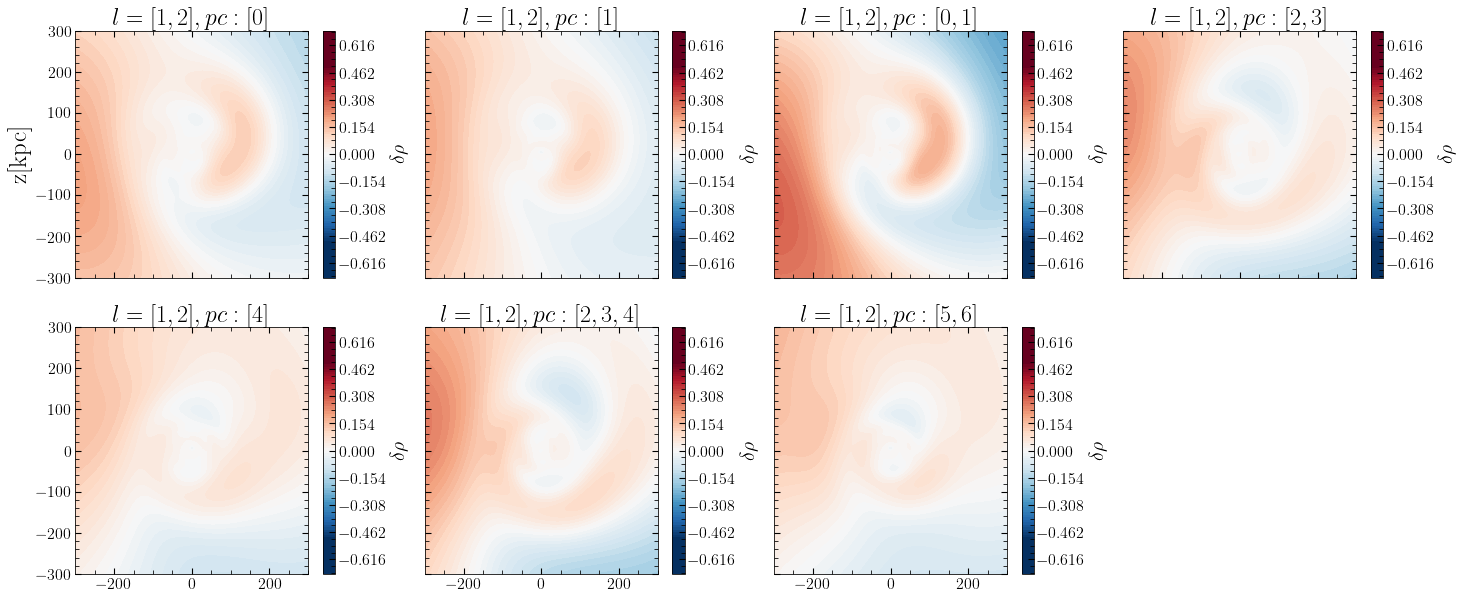

In [35]:
## removing n, 0, 1, 2  for l=1, l=2
pcs_densities(ssa, mwcoefs, mwbasis, rho_mon, pcs=[[0], [1], [0,1], [2,3], [4], [2,3,4], [5,6]])


computing 7 pcs


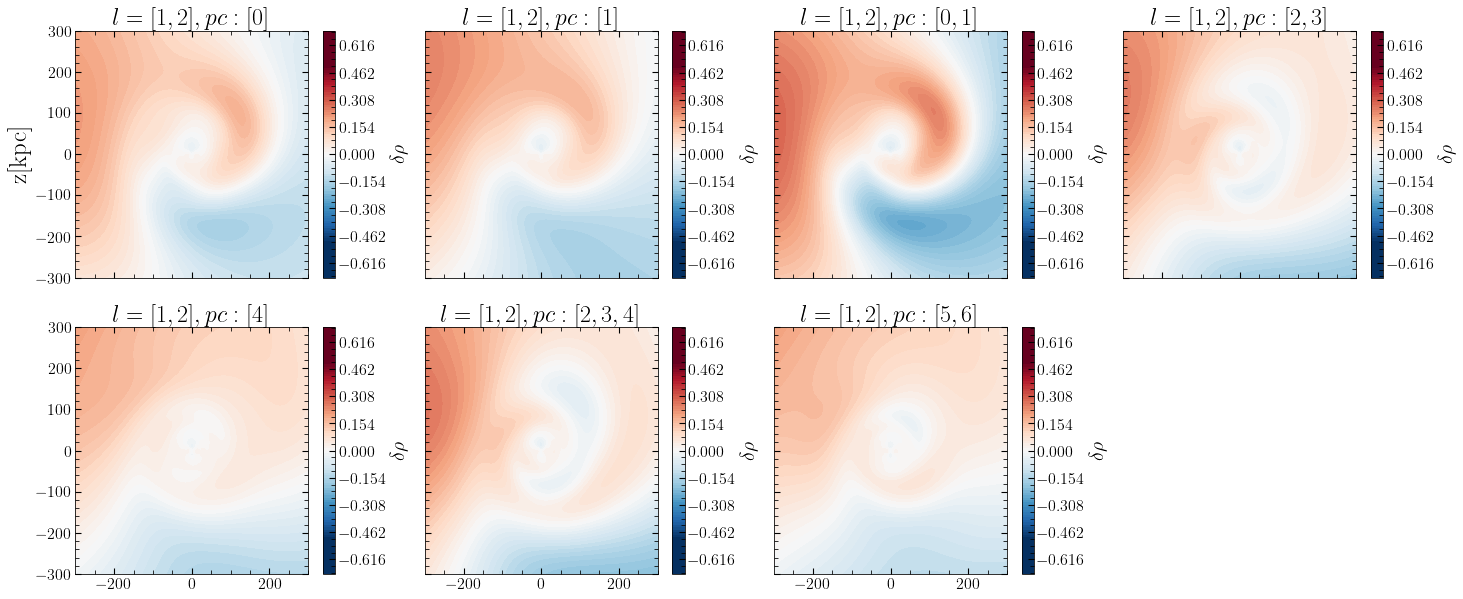

In [45]:
# removing n=0 for l=1, l=2
pcs_densities(ssa, mwcoefs, mwbasis, rho_mon, pcs=[[0], [1], [0,1], [2,3], [4], [2,3,4], [5,6]])

In [40]:
ssa.reconstruct(list(np.arange(1,2)))
#ssa.reconstruct()
mwcoefs.zerodata() # <---replace with reconstructed
newdata = ssa.getReconstructed()
print('newdata is a', type(newdata))



newdata is a <class 'dict'>


In [41]:
rho_mon_pc2, rho_all_pc2, grid = slice_fields(mwbasis, mwcoefs, npoints=100, time=2.1, rmax=300)


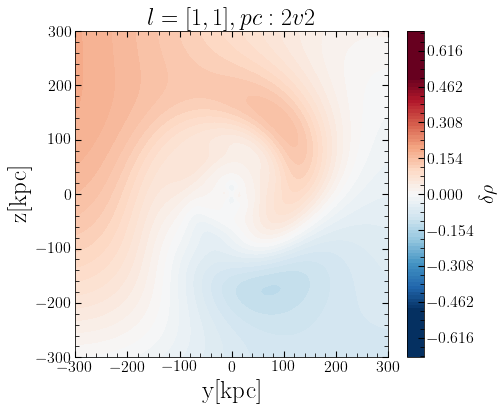

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
fig.patch.set_facecolor('w')
#plt.plot(pos[:,1]-posm[:,1], pos[:,2]-posm[:,2], c='k')
im = ax.contourf(grid[0], grid[1], (rho_mon+rho_all_pc2)/rho_mon - 1, levels=np.linspace(-0.7, 0.7, 101), 
                 cmap='RdBu_r', vmin=-0.5, vmax=0.5)

cbar = fig.colorbar(im)
cbar.set_label(r'$\delta \rho$')
ax.set_xlim(-300, 300) 
ax.set_ylim(-300, 300)
ax.set_xlabel(r'$\rm{y[kpc]}$', fontsize=25)
ax.set_ylabel(r'$\rm{z[kpc]}$', fontsize=25)
plt.title(r'$l=[1, 1], pc: 2v2$')
plt.savefig('wake_l_1-2_pc2v2_w0.25.png',bbox_inches='tight')

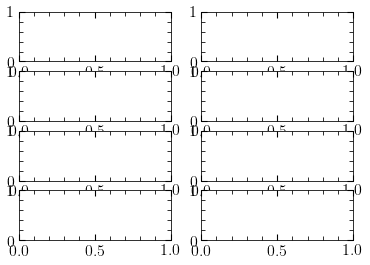

In [43]:
fig, ax = plt.subplots(4, 2)

In [35]:
for i in range(0, 393):
    
    print(i)
    try:
        rho_mon_pc1, rho_all_pc1, grid = slice_fields(mwbasis, mwcoefs, npoints=100, time=times[i], rmax=300)
    except:
        pass
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    fig.patch.set_facecolor('w')
    #plt.plot(pos[:,1]-posm[:,1], pos[:,2]-posm[:,2], c='k')
    ax.set_title(r'$\rm{MW-LMC} PC 2-5, l=2$' + '$\ t={:.2f}$'.format(i*0.02) + r'$\ \rm{Gyr}$', fontsize=25)
    im = ax.contourf(grid[0], grid[1], (rho_mon+rho_all_pc1)/rho_mon - 1, levels=np.linspace(-0.3, 0.3, 101), cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    #ax.contour(grid[0], grid[1], (rho_mon+rho_all)/rho_mon - 1, levels=np.linspace(-0.5, 0.5, 8), colors='k', lw=1.0, vmin=-0.5, vmax=0.5)
    #fig.colorbar(im)
    ax.set_xlim(-300, 300) 
    ax.set_ylim(-300, 300)
    ax.set_xlabel(r'$\rm{y[kpc]}$', fontsize=25)
    ax.set_ylabel(r'$\rm{z[kpc]}$', fontsize=25)
    cbar = fig.colorbar(im)
    cbar.set_label(r'$\delta \rho$', fontsize=25)

    plt.savefig('../../figures/wake_GC19_exp/pc5-6_l1_mwlmc5_exp_{:03d}.png'.format(i), bbox_inches='tight')
    plt.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#ssa.reconstruct([2, 3])

#mwcoefs.zerodata() # <---replace with reconstructed
#newdata = ssa.getReconstructed()
#print('newdata is a', type(newdata))



In [14]:
print("Got coefs for name=", mwcoefs.getName())

# get all keys for l=1 harmonic order
#
#print("Keys=", keylst)

#config = {"mw": (mwcoefs, keylst1, [])}

#keylst = np.loadtxt('./petersen/mike_mwlmc_pow_cutkeylist.txt')
keylst2 = np.loadtxt('./petersen/mike_mwlmc_pow_cut_20keylist.txt')

#config = {"mw": (mwcoefs, keylst.astype(int).tolist(), [])}
config2 = {"mw": (mwcoefs, keylst2.astype(int).tolist(), [])}

window = int(len(mwcoefs.Times())/2)
npc = 20

print("Window={} PC number={}".format(window, npc))

#ssa = pyEXP.mssa.expMSSA(config, window, npc)
ssa2 = pyEXP.mssa.expMSSA(config2, window, npc)

Got coefs for name= mw
Window=1100 PC number=20
---- Eigen is using 40 threads


In [16]:
ev2 = ssa2.eigenvalues()

In [33]:
#ssa.restoreState('./petersen/mike_mwlmc_pow_cuttop_100_powcoeff')

RuntimeError: expMSSA::restoreState: saved state has numT=1301 but expMSSA expects numT=2201.
Can't restore mssa state!

In [133]:
#ssa2.restoreState('mike_mwlmc_pow_cut_20top_100_powcoeff')

RuntimeError: expMSSA::restoreState: saved state has numT=1301 but expMSSA expects numT=2201.
Can't restore mssa state!

In [17]:
#ev1 = ssa.eigenvalues()


In [ ]:
ev2 = ssa2.eigenvalues()

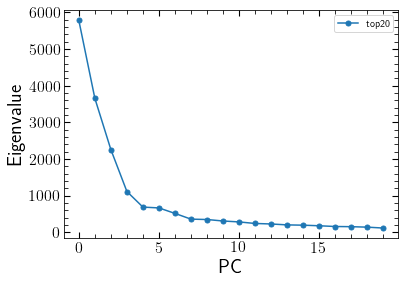

In [18]:
#plt.plot(ev1, '-o', lw=1.5, label='top100')
plt.plot(ev2, '-o', lw=1.5, label='top20')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')
plt.legend()
#plt.savefig('pc_eigenvalues.png', bbox_inches='tight')

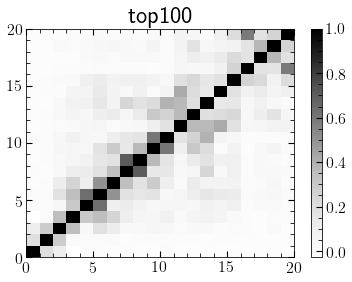

In [12]:
ssa.reconstruct([*range(npc)])
mat = ssa.wCorrAll()
x = plt.pcolormesh(mat, cmap='Greys')
plt.title("top100")
plt.colorbar(x)
plt.savefig('wmat_top100.png', bbox_inches='tight')

In [ ]:
mwcoefs.WriteH5Coefs('')

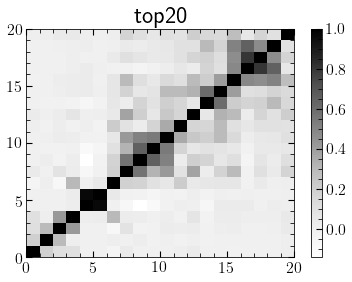

In [19]:
ssa2.reconstruct([*range(npc)])
mat2 = ssa2.wCorrAll()
x2= plt.pcolormesh(mat2, cmap='Greys')
plt.title("top20")
plt.colorbar(x2)
plt.savefig('wmat_top20.png', bbox_inches='tight')

In [22]:
rho_mon, rho_all, grid = slice_fields(mwbasis, mwcoefs, npoints=100, time=2.0)

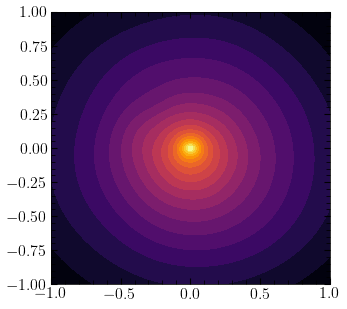

In [23]:
plt.figure(figsize=(5,5))
plt.contourf(grid[0], grid[1], np.log10(rho_mon+rho_all), 20, cmap='inferno')

In [25]:
ssa2.reconstruct([2, 3, 4, 5, 6, 7, 8]) # reconstruct every channel
mwcoefs.zerodata()
# copying back the origin alcoeff
ssa2.getReconstructed()


{'mw': <pyEXP.coefs.SphCoefs at 0x1555104ed970>}

In [28]:
rho_mon, rho_all, grid = slice_fields(mwbasis, mwcoefs, npoints=100, time=2.0)


Text(-0.8, 0.8, '$t=$0.01 Gyr')

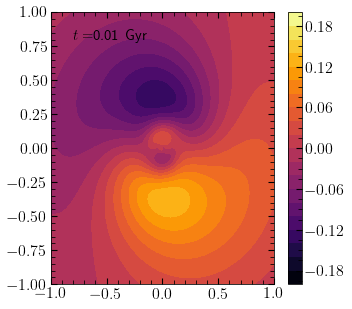

In [34]:
plt.figure(figsize=(5,5))
plt.contourf(grid[0], grid[1], (rho_all)/rho_mon, np.linspace(-0.2, 0.2, 21), cmap='inferno')
plt.colorbar()
plt.text(-0.8, 0.8, r'$t=${:.2f} Gyr'.format(0.01), fontsize=15)

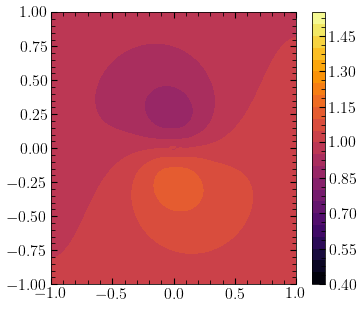

In [35]:
rho_mon, rho_all, grid = slice_fields(mwbasis, mwcoefs, npoints=100, time=1.3)
plt.figure(figsize=(5.5,5))
plt.contourf(grid[0], grid[1], (rho_mon+rho_all)/rho_mon, levels = np.linspace(0.4, 1.55, 24), cmap='inferno')
plt.colorbar()

In [9]:
for i in range(0, 130):
    rho_mon, rho_all, grid = slice_fields(mwbasis, mwcoefs, npoints=100, time=i/100.)
    fig = plt.figure(figsize=(5.5,5))
    im = plt.contourf(grid[0], grid[1], (rho_mon+rho_all)/rho_mon, np.linspace(0.4, 1.55, 24), cmap='inferno')
    #im = plt.contourf(grid[0], grid[1], (rho_mon+rho_all)/rho_mon, np.linspace(0.8, 1.2, 21), cmap='inferno')
    cbar = plt.colorbar(im)
    plt.xlabel(r'$y$')
    plt.ylabel(r'$z$')
    plt.title('PC2_8 top 100')
    plt.text(-0.8, 0.8, r'$t=${:.2f} Gyr'.format(i/100.), fontsize=16)  
    cbar.set_label(r'$\delta \rho$')
    fig.patch.set_facecolor('w')
    fig.patch.set_alpha(1)
    plt.savefig('./plots/mwlmc_mike_dens_top100_{:03d}.png'.format(i), bbox_inches='tight', pad_inches=0.4, dpi=120)
    plt.close()

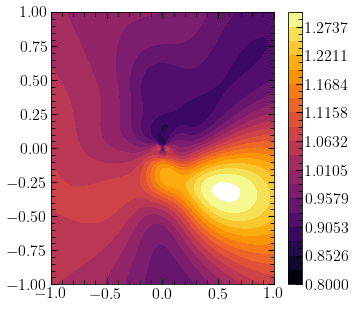

In [99]:
#f compare  and g compare to see matrix of reconstructed llook at the mssa class

In [133]:
a, g = ssa.contrib()

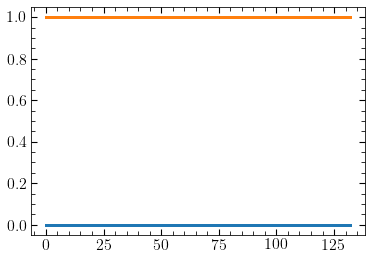

In [148]:
plt.plot(a[3])
plt.plot(a[4])

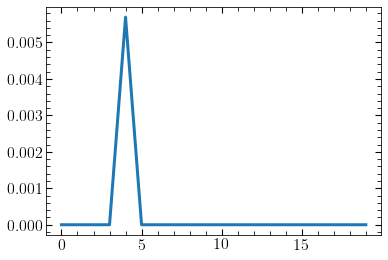

In [140]:
plt.plot(g[:,4])


In [20]:
freq1, power1 = ssa.pcDFT()


In [21]:
freq2, power2 = ssa2.pcDFT()


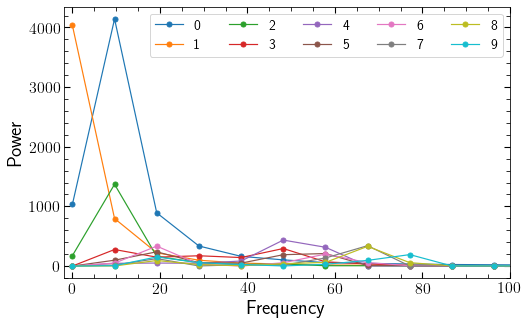

In [22]:
plt.figure(figsize=(8,5))
for i in range(10):
    plt.plot(freq1[:], power1[:,i], '-o' , label=str(i), lw=1.2)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(ncol=5, fontsize=14)
plt.xlim(-2, 100)
plt.savefig('power_spectrum_MWLMC_petersen_top100.png', bbox_inches='tight')

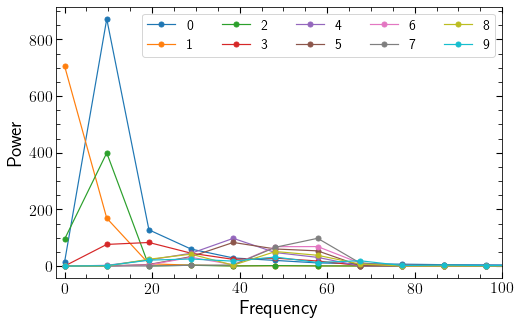

In [24]:
plt.figure(figsize=(8,5))
for i in range(10):
    plt.plot(freq2[:], power2[:,i], '-o' , label=str(i), lw=1.2)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(ncol=5, fontsize=14)
plt.xlim(-2, 100)
plt.savefig('power_spectrum_MWLMC_petersen_top20.png', bbox_inches='tight')

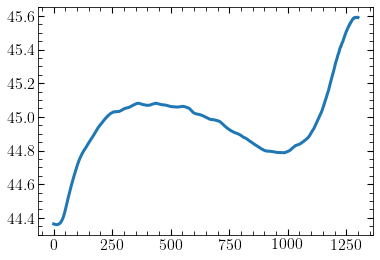

In [5]:
slicelot(mwcoefs.Power()[:,0])

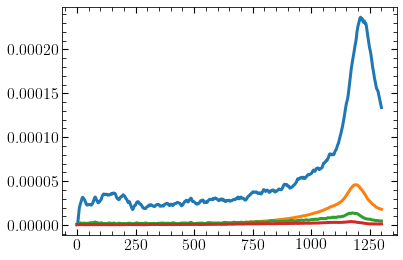

In [6]:
for l in range(2,6):
    plt.plot(mwcoefs.Power()[:,l]/mwcoefs.Power()[:,0])

In [7]:
np.shape(mwcoefs.Power()/mwcoefs.Power()[0])

(1301, 7)

In [8]:
np.shape(mw_coeff_arr)

(28, 18, 1301)

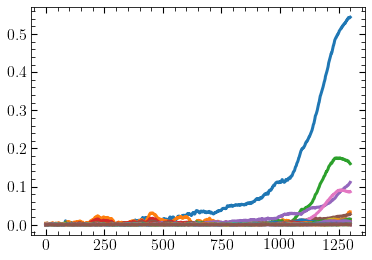

In [9]:
for n in range(18):
    plt.plot(np.sqrt(mw_coeff_arr[1,n,:].real**2 + mw_coeff_arr[1,n,:].imag**2))
    plt.plot(np.sqrt(mw_coeff_arr[2,n,:].real**2 + mw_coeff_arr[2,n,:].imag**2))

In [10]:
power = np.sum(np.sqrt(mw_coeff_arr[:,:,:].real**2 + mw_coeff_arr[:,:,:].imag**2), axis=2)

In [37]:
np.shape(power1)

(327, 20)

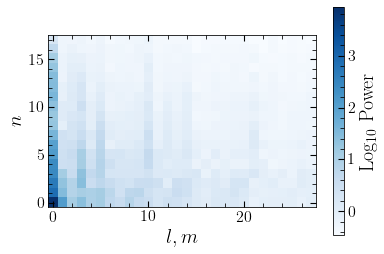

In [11]:
plt.imshow(np.log10(power.T), cmap='Blues', origin='lower')
cbar = plt.colorbar(orientation='vertical')
cbar.set_label(r'$\rm{Log_{10}\ Power}$')
plt.xlabel('$l,m$')
plt.ylabel('$n$')
plt.savefig('all_coeff_power.png', bbox_inches='tight')

In [50]:
power_cut = np.sort(power.flatten())

In [51]:
power_cut[::-1][100]

25.93963456684285

In [59]:
len(power.flatten())

6540

In [56]:
powcut = np.where(power.flatten()<power_cut[::-1][100])

In [34]:
#plt.semilogy(power2.flatten()[::-1])


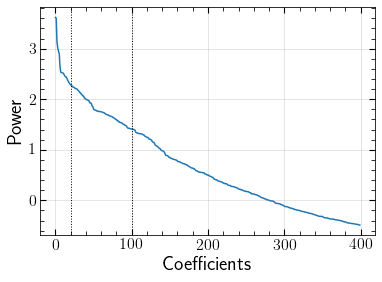

In [47]:
plt.plot(np.log10(np.sort(power1.flatten())[::-1][:400]), lw=1.5)
plt.grid(alpha=0.4)
plt.xlabel('Coefficients')
plt.ylabel('Power')
plt.axvline(100, c='k', lw=1, ls=':')
plt.axvline(20, c='k', lw=1, ls=':')
plt.savefig('coeff_power.png', bbox_inches='tight' )

In [16]:
power_sel = power

In [17]:
power_sel[powcut] = 0

/tmp/ipykernel_893667/654349146.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(power_sel).T, origin='lower')


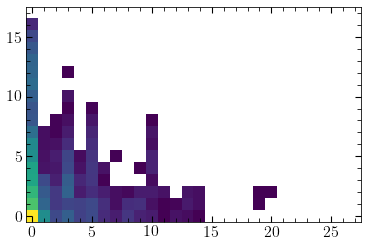

In [19]:
plt.imshow(np.log10(power_sel).T, origin='lower')
#plt.saveg

In [20]:
llist =  np.where(power_sel!=0)[0]
nlist =  np.where(power_sel!=0)[1]

In [21]:
np.shape(power_sel)

(28, 18)

In [22]:
k = 0
list_array = np.zeros((np.shape(power_sel)[0], 3))
for l in range(7):
    for m in range(l+1):
        print(k, l, m)
        list_array[k] = [k, l, m]
        k+=1


0 0 0
1 1 0
2 1 1
3 2 0
4 2 1
5 2 2
6 3 0
7 3 1
8 3 2
9 3 3
10 4 0
11 4 1
12 4 2
13 4 3
14 4 4
15 5 0
16 5 1
17 5 2
18 5 3
19 5 4
20 5 5
21 6 0
22 6 1
23 6 2
24 6 3
25 6 4
26 6 5
27 6 6


In [23]:
make_list = []
for ll in range(100):
    ln = llist[ll]
    make_list.append([int(list_array[ln][1]), int(list_array[ln][2]), nlist[ll]])

/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


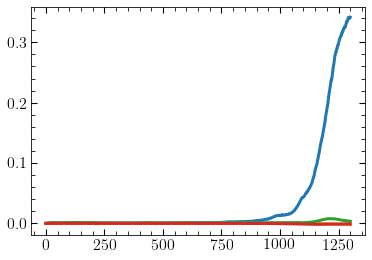

In [24]:
#plt.plot(mw_coeff_arr[0,0,:])
plt.plot(np.sum(mw_coeff_arr[1,:,:]**2, axis=0))
plt.plot(np.sum(mw_coeff_arr[2,:,:]**2, axis=0))
plt.plot(np.sum(mw_coeff_arr[3,:,:]**2, axis=0))
plt.plot(np.sum(mw_coeff_arr[4,:,:]**2, axis=0))

In [25]:
def slice_fields(basis_plot, coeff, npoints =100, t=0.0):
    x = np.linspace(-1, 1, npoints)
    xgrid = np.meshgrid(x, x)
    xg = xgrid[0].flatten()
    yg = xgrid[1].flatten()

    N = len(xg)
    print(N)
    rho0 = np.zeros_like(xg)
    pot0 = np.zeros_like(xg)
    rho = np.zeros_like(xg)
    pot = np.zeros_like(xg)
    basis_plot.set_coefs(coeff.getCoefStruct(t))
    for k in range(0, N):
        rho0[k], pot0[k], rho[k], pot[k], fx, fy, fz = basis_plot.getFields(0, xg[k], yg[k])
        # returns cartesian 
        # slices return r, t, p

    return rho0.reshape(npoints, npoints), rho.reshape(npoints, npoints)

In [56]:
for t in range(0, 130):
    rho0, rhoall  = slice_fields(mwbasis, mwcoefs, 100, t/100)
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    im = ax.imshow(((rho0+rhoall)/rho0) - 1, cmap='RdBu_r', origin='lower', vmin=-0.7, vmax=0.7, 
                      extent=[-1, 1, -1, 1])
    cbar = plt.colorbar(im)
    ax.set_xlabel('$y$')
    ax.set_ylabel('$z$')
    cbar.set_label(r'$\Delta \rho$')
    #im = ax[0].imshow(np.log10(rho0+rhoall), cmap='inferno', origin='lower', vmin=-0.7, vmax=0.7, 
    #                  extent=[-1, 1, -1, 1])
    plt.title('$t=$'+ '${:.2f}$'.format(t/100.0) + r'\ $\rm{Gyr}$')
    plt.savefig('./plots/density_mwlmc_{:03d}.png'.format(int(t)), bbox_inches='tight')
    plt.close()

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [26]:
# Create the keys (lists) of the coefficients that are going to go to mssa
keylst0 = mwcoefs.makeKeys([0])
keylst1 = mwcoefs.makeKeys([1])

In [27]:
keylst=[]
for i in range(18):
    keylst.append(keylst0[i])
for i in range(18):
    keylst.append(keylst1[i])


In [28]:
len(keylst0)

18

In [22]:
mwcoefs.makeKeys([2])

[[2, 0, 0],
 [2, 0, 1],
 [2, 0, 2],
 [2, 0, 3],
 [2, 0, 4],
 [2, 0, 5],
 [2, 0, 6],
 [2, 0, 7],
 [2, 0, 8],
 [2, 0, 9],
 [2, 0, 10],
 [2, 0, 11],
 [2, 0, 12],
 [2, 0, 13],
 [2, 0, 14],
 [2, 0, 15],
 [2, 0, 16],
 [2, 0, 17],
 [2, 1, 0],
 [2, 1, 1],
 [2, 1, 2],
 [2, 1, 3],
 [2, 1, 4],
 [2, 1, 5],
 [2, 1, 6],
 [2, 1, 7],
 [2, 1, 8],
 [2, 1, 9],
 [2, 1, 10],
 [2, 1, 11],
 [2, 1, 12],
 [2, 1, 13],
 [2, 1, 14],
 [2, 1, 15],
 [2, 1, 16],
 [2, 1, 17],
 [2, 2, 0],
 [2, 2, 1],
 [2, 2, 2],
 [2, 2, 3],
 [2, 2, 4],
 [2, 2, 5],
 [2, 2, 6],
 [2, 2, 7],
 [2, 2, 8],
 [2, 2, 9],
 [2, 2, 10],
 [2, 2, 11],
 [2, 2, 12],
 [2, 2, 13],
 [2, 2, 14],
 [2, 2, 15],
 [2, 2, 16],
 [2, 2, 17]]

In [23]:
keylst

[[0, 0, 0],
 [0, 0, 1],
 [0, 0, 2],
 [0, 0, 3],
 [0, 0, 4],
 [0, 0, 5],
 [0, 0, 6],
 [0, 0, 7],
 [0, 0, 8],
 [0, 0, 9],
 [0, 0, 10],
 [0, 0, 11],
 [0, 0, 12],
 [0, 0, 13],
 [0, 0, 14],
 [0, 0, 15],
 [0, 0, 16],
 [0, 0, 17],
 [1, 0, 0],
 [1, 0, 1],
 [1, 0, 2],
 [1, 0, 3],
 [1, 0, 4],
 [1, 0, 5],
 [1, 0, 6],
 [1, 0, 7],
 [1, 0, 8],
 [1, 0, 9],
 [1, 0, 10],
 [1, 0, 11],
 [1, 0, 12],
 [1, 0, 13],
 [1, 0, 14],
 [1, 0, 15],
 [1, 0, 16],
 [1, 0, 17]]

In [29]:
print("Got coefs for name=", mwcoefs.getName())

# get all keys for l=1 harmonic order
#
#print("Keys=", keylst)

#config = {"mw": (mwcoefs, keylst1, [])}

config = {"mw": (mwcoefs, keylst0[0:10], [])}

window = int(len(mwcoefs.Times())/2)
npc = 10

print("Window={} PC number={}".format(window, npc))

ssa = pyEXP.mssa.expMSSA(config, window, npc) # initialize ssa instance
ev = ssa.eigenvalues() # this is where mssa runs

times = mwcoefs.Times()
pc    = ssa.getPC()

Got coefs for name= 
Window=650 PC number=10
---- Eigen is using 1 threads
shape U = 6500 x 10


In [31]:
ssa.saveState('test_saving_ssa_state')

In [ ]:
ssa2 = 

TypeError: restoreState(): incompatible function arguments. The following argument types are supported:
    1. (self: pyEXP.mssa.expMSSA, prefix: str) -> None

Invoked with: 'test_saving_ssa_state_mssa.h5'

In [4]:
#ssa2 = pyEXP.mssa.expMSSA(config, window, npc)
ssa2.restoreState('test_saving_ssa_state')

NameError: name 'ssa2' is not defined

Text(0, 0.5, 'Eigenvalue')

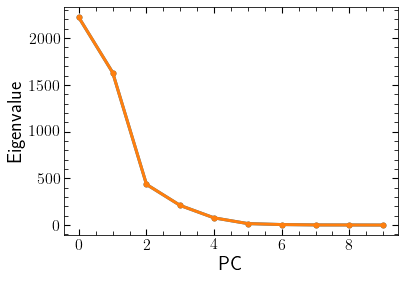

In [36]:
plt.plot(ev, '-o')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')

plt.plot(ssa2.eigenvalues(), '-o')
plt.xlabel('PC')
plt.ylabel('Eigenvalue')

In [26]:
ssa.reconstruct([0,1]) # reconstruct every channel
#newdata['mw'].zerodata()
mwcoefs.zerodata()
# copying back the origin alcoeff
ssa.getReconstructed()

{'mw': <pyEXP.coefs.SphCoefs at 0x155511776bb0>}

In [32]:
!pwd

/mnt/home/nico/projects/time-dependent-BFE/scripts/mssa/petersen


In [44]:
np.shape(mwcoefs.getAllCoefs())

(28, 18, 1301)

In [57]:
mwcoefs.getAllCoefs()[1, 0, :]

array([-0.00577997+0.j, -0.00568881+0.j, -0.00561705+0.j, ...,
       -0.54795866+0.j, -0.54792831+0.j, -0.5478561 +0.j])

In [88]:
nt = pc.shape[0]
for i in range(0,10):
    plt.plot(times[:nt], pc[:,i], label=str(i), alpha=0.7)
plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()

NameError: name 'pc' is not defined

# Reconstruct

In [16]:

# make a deepcopy of the original coefs
#originalmwcoefs = pyEXP.coefs.Coefs.deepcopy(mwcoefs)
#originalmwcoefs = pyEXP.coefs.Coefs.factory('outcoef.mw.run9mlde')

#mwcoefs_mon = pyEXP.coefs.Coefs.deepcopy(mwcoefs)
#mwcoefs_mon = pyEXP.coefs.Coefs.factory('outcoef.mw.run9mlde')



# this needs arguments
# creates intenrally the reconstrudes series and denormalized variables
#ssa.reconstruct([1])

# copying back the origin alcoeff
#mwcoefs.zerodata()  # 
#newdata = ssa.getReconstructed()

#print('newdata is a', type(newdata))

In [17]:
#np.shape(newdata['mw'].getAllCoefs())

In [18]:
#for n in range(18):
#    plt.plot(np.sqrt(mw_coeff_arr[1,n,:].real**2 + mw_coeff_arr[1,n,:].imag**2))
#    plt.plot(np.sqrt(mw_coeff_arr[2,n,:].real**2 + mw_coeff_arr[2,n,:].imag**2))

In [19]:
ssa.reconstruct([0,1]) # reconstruct every channel
#newdata['mw'].zerodata()
mwcoefs.zerodata()
# copying back the origin alcoeff
ssa.getReconstructed()

{'mw': <pyEXP.coefs.SphCoefs at 0x155548c47630>}

In [21]:
mwcoefs.getAllCoefs()

array([[[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        ...,
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j]],

       [[-0.00530535+0.j, -0.00521514+0.j, -0.00514432+0.j, ...,
         -0.54797166+0.j, -0.54794577+0.j, -0.54787848+0.j],
        [-0.00117737+0.j, -0.00115185+0.j, -0.00113157+0.j, ...,
         -0.18954845+0.j, -0.18949642+

In [21]:
newdata['mw'].getAllCoefs()

array([[[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        ...,
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
          0.        +0.j,  0.        +0.j,  0.        +0.j]],

       [[-0.09717611+0.j, -0.09715236+0.j, -0.09713088+0.j, ...,
         -0.55954338+0.j, -0.55982618+0.j, -0.56006723+0.j],
        [-0.02376876+0.j, -0.02376256+0.j, -0.02375716+0.j, ...,
         -0.18882529+0.j, -0.18883061+

/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz9l-python-3.9.12-view/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/sw/nix/store/6a11b1qfnfwxjzs8q4xnlid1z3mvkz

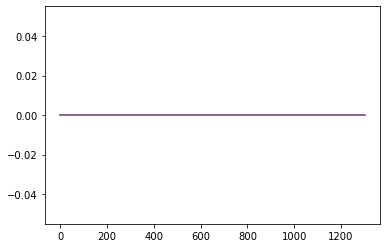

In [71]:
for i in range(0, 10, 2):
    ssa.reconstruct([i, i+1]) # reconstruct every channel
    newdata['mw'].zerodata()
    # copying back the origin alcoeff
    newdata = ssa.getReconstructed()
    plt.plot(np.sum(newdata['mw'].getAllCoefs()[i,:,:]**2, axis=0))

In [63]:
rho0_rec, rhoall_rec  = slice_fields(mwbasis, newdata['mw'])

10000


In [19]:
ssa.getRCkeys()

[[1, 0, 0, 0, 0],
 [1, 0, 1, 0, 0],
 [1, 0, 2, 0, 0],
 [1, 0, 3, 0, 0],
 [1, 0, 4, 0, 0],
 [1, 0, 5, 0, 0],
 [1, 0, 6, 0, 0],
 [1, 0, 7, 0, 0],
 [1, 0, 8, 0, 0],
 [1, 0, 9, 0, 0]]

In [23]:
recon = ssa.getRC([1,0,0,0,0])

In [27]:
recon.shape[1]

10

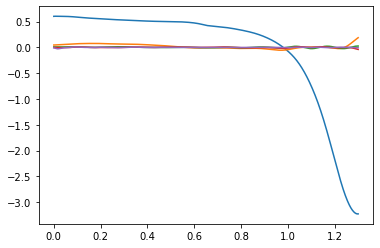

In [29]:
for i in range(0, recon.shape[1], 2):
    plt.plot(times, recon[:,i]+recon[:,i+1], label=str(i))

In [40]:
newdata['mw']

In [33]:
newdata = ssa.getReconstructed(True) # <---zero all but reconstructed
print('newdata is a', type(newdata))

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
lmcconfig = """
id: sphereSL
parameters:
  numr: 4000
  rmin: 0.000001
  rmax: 5.0
  Lmax: 6
  nmax: 24
  scale: 1.0
  modelname: ErkalLMC.model
  cachename: SLGridSph.lmc.pyEXP
"""
lmcbasis = pyEXP.basis.Basis.factory(lmcconfig)

lmccoefs = pyEXP.coefs.Coefs.factory('outcoef.lmc.run9mlde')

The cosine fields give a pair of primary PCs. The noise is spread into the remaining PCs. I'm not sure why the last ev is so tiny.  I think it's likely to be RedSVD since that behavior is time-series rank dependent.

### 4.b Look at the first 10 PCs

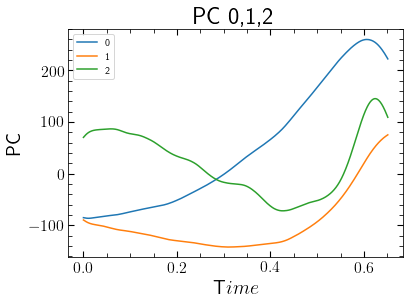

In [101]:
pc = ssa.getPC()
nt = pc.shape[0]
for i in range(0, 3):
    plt.plot(mwcoefs.Times()[:nt], pc[:,i], label=str(i), lw=1.5)
plt.xlabel('T$ime$')
plt.ylabel('PC')
plt.legend()
plt.title("PC 0,1,2")
plt.savefig('pcs_0_2.png', bbox_inches='tight')

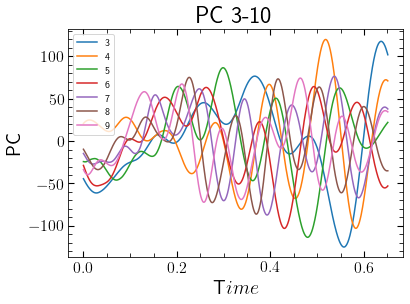

In [99]:
pc = ssa.getPC()
nt = pc.shape[0]
for i in range(3, 10):
    plt.plot(mwcoefs.Times()[:nt], pc[:,i], label=str(i), lw=1.5)
plt.xlabel('T$ime$')
plt.ylabel('PC')
plt.legend()
plt.title("PC 3-10")
plt.savefig('pcs_3_10.png', bbox_inches='tight')

In [ ]:
pc = ssa.getPC()
nt = pc.shape[0]
for i in range(0,2):
    plt.plot(coefs.Times()[:nt], pc[:,i], label=str(i))
plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title("PC 0,1")
plt.show()

for i in range(2,8):
    plt.plot(coefs.Times()[:nt], pc[:,i], label=str(i))
plt.xlabel('Time')
plt.ylabel('PC')
plt.legend()
plt.title('PC 2,3,4,5,6,7')
plt.show()

for i in range(8,10):
    plt.plot(coefs.Times()[:nt], pc[:,i], label=str(i))
plt.xlabel('Time')
plt.ylabel('PC 8,9')
plt.legend()
plt.show()


The first two PCs contain the sinusoidal variation.  The remaining PCs represent the noise.  Not sure what's up with the last ev...

### 4.c Compute the power spectrum of the PCs

In [ ]:
freq, power = ssa.pcDFT()
for i in range(power.shape[1]):
    plt.plot(freq[0:20], power[0:20,i], '-o', label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()

We expect our power at $f=1$ and that's what we find!

### Compute the power spectrum of the reconstruction

In [ ]:
ssa.reconstruct([0, 1])

# Show the keys as a demonstration
ssa.getRCkeys()

In [16]:
recon = ssa.reconstruct([*range(npc)])

In [17]:
recon

In [69]:
recon2 = ssa.getRC([0, 0])
for i in range(recon2.shape[1]):
    plt.plot(coefs.Times(), recon2[:,i], label=str(i))
plt.xlabel('time')
plt.ylabel('column(0)')
plt.legend()
plt.show()

RuntimeError: expMSSA:getRC: key not found

### 4.d Reconstruction

In [19]:
ssa.reconstruct([*range(10)])

In [20]:
#new_data = ssa.getReconstructed()

In [21]:
recon = ssa.getRC([0,0])

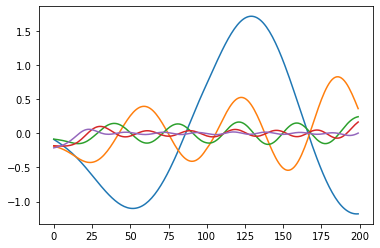

In [22]:
plt.plot(recon[:,0] + recon[:,1])
plt.plot(recon[:,2] + recon[:,3])
plt.plot(recon[:,4] + recon[:,5])
plt.plot(recon[:,6] + recon[:,7])
plt.plot(recon[:,8] + recon[:,9])



Redo the reconstructions for all 10 PCs.  The look at the reconstruction for the first data column.

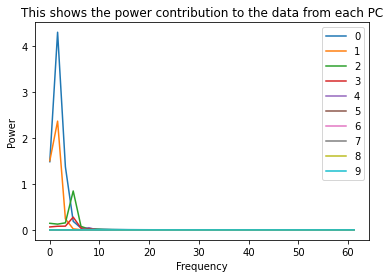

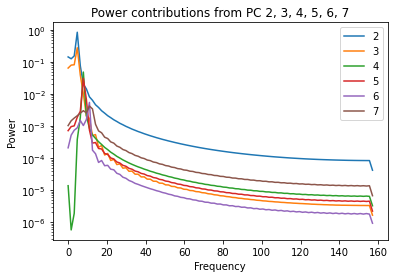

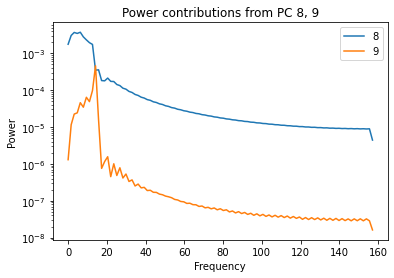

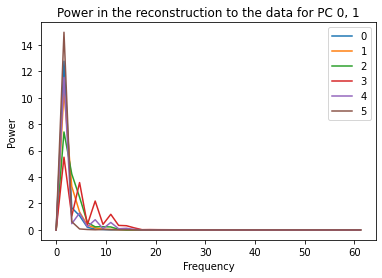

In [23]:
key = [0, 0] # First column, first data set (there is only one data set here)

freq, power = ssa.singleDFT(key)

for i in range(power.shape[1]):
    plt.plot(freq[0:40], power[0:40,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('This shows the power contribution to the data from each PC')
plt.legend()
plt.show()

for i in range(2, 8):
    plt.semilogy(freq, power[:,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power contributions from PC 2, 3, 4, 5, 6, 7')
plt.legend()
plt.show()

for i in range(8, 10):
    plt.semilogy(freq, power[:,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power contributions from PC 8, 9')
plt.legend()
plt.show()

freq, power = ssa.channelDFT()
for i in range(power.shape[1]):
    plt.plot(freq[0:40], power[0:40,i], label=str(i))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power in the reconstruction to the data for PC 0, 1')
plt.legend()
plt.show()

This shows the power contribution to the data column 0 from each PC.  It's all PC 0, 1, of course, at the same frequency ($f=1$) as the PC itself.   The remaining PCs contain the random fields; these have a flat power spectrum expected for pure white noise.

In [ ]:
mat = ssa.wCorrAll()
x = plt.pcolormesh(mat, cmap='Greys')
plt.title("All channels")
plt.colorbar(x)
plt.show()

# 5. Field reconstruction

In [20]:
def hernquist_halo(r, a):
    return 1 / ( 2*np.pi * (r/a) * (1 + r/a)**3)

In [31]:
R, D, M, P = makemodel.makemodel(hernquist_halo, 1E12, [40.85], pfile='hernquist_table.txt')

! Scaling:  R= 10000.0   M= 1000000000000.0
1.0 14789769.339215906 14789769.339215906 14789769.339215906


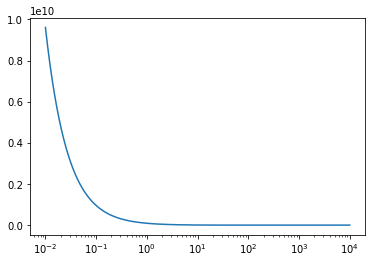

In [32]:
plt.semilogx(R, D)

In [23]:
config2 = """
---
id: sphereSL
parameters:
  numr: 2000
  rmin: -2
  rmax: 4
  Lmax: 1
  nmax: 10
  scale: 40
  modelname: hernquist_table.txt
...
"""


In [24]:
basis = pyEXP.basis.Basis.factory(config2)

---- SLGridSph::read_cached_table: trying to read cached table . . .
---- SLGridSph::write_cached_table: done!!


SLGridSph: opened <.slgrid_sph_cache>


In [25]:
times=np.arange(0, 4, 0.02)
print(len(times))
pmin = [-1.0, -1.0, 0.0]
pmax = [1.0, 1.0, 0.0]
grid = [40, 40, 0]

fields = pyEXP.field.FieldGenerator([0], pmin, pmax, grid)


200
